## Optimized algorithm for complete qubit estate tomography in NISQ quantum computers.

This Jupyter notebook has a brief demonstration of a new algorithm for doing indirect qubit state estimation using auxiliary qubits. Before abording this notebook I recommend first to follow the <a href="Saavedra_model.ipynb" target="_blank">notebook</a> about the theoretical model that we are using for doing the tomography process.

We already know that we are going to estimate the inital state of a qubit $S$ using two auxiliary qubits $A$ and $B$ as in the following figure.


<center>
    <img src="figures/System.png" width=200px>
</center>

In this notebook we will suggest a new evolution operator for doing the state tomography. So we will move forward to the design of the circuit and we will see its performance in a quantum computer.

In [40]:
## Imports can be seen in the imports.ipynb file
%run imports.ipynb
IBMQ.load_account()
pi = np.pi
j = complex(0,1)

ibmqfactory.load_account:WARNING:2022-03-28 12:36:40,481: Credentials are already in use. The existing account in the session will be replaced.


### Qubits initialization

For this simulation, first, we have to initialize the qubits that we are going to use. In this case the $A$ and $B$ meters have to be initialized in the state $|+\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle\right)$. On the other hand, the qubit $S$ is initialized in an arbitrary state $|\psi^S\rangle = c_0|0\rangle + c_1 |1\rangle$. This state can be parametrized in terms of the angles of a $U$ gate,
$$U_{gate}(\theta,\phi,\lambda) = \begin{pmatrix}
\cos(\theta/2) & -e^{i\lambda}\sin(\theta/2) \\
e^{i\phi}\sin(\theta/2) & e^{i\lambda + i\phi}\cos(\theta/2) 
\end{pmatrix} .$$
So we define the initialization function.

In [41]:
def Initialization(angles = [0,0,0]):
    
    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)

    #Initialice qubits
    qc.h(qr[0])                                    #A meter
    qc.h(qr[2])                                    #B meter
    qc.u(angles[0],angles[1],angles[2],[qr[1]])    #System
    
    Init_gate = qc.to_gate()
    Init_gate.name= "Initialization"
    
    return Init_gate

### Evolution operator

Now we have to implement the evolution operator. In this case we are going to propose a new evolution operator that just needs 2 CNOT gates for doing optimal qubit state estimation. But, it has a total of $12$ free parameters, which are the angles of the $4$ general rotations that we are implementing, two in the meter $A$ and two in the meter $B$.

In [42]:
def U_operator(A=[0,0,0,0,0,0],B=[0,0,0,0,0,0]):
    
    ## A y B are vectors with the rotation angles of the meters A y B
    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)
    
    #####==================================#####
    #####======= Evolution operator =======#####
    #####==================================#####


       
    ## We apply rotations around a CNOT between the S and A qubits
    qc.u(A[0],A[1],A[2],qr[0])   
    qc.cx(qr[1],qr[0])
    qc.u(A[3],A[4],A[5],qr[0])
    
    
    ## We change the basis of the S qubit
    qc.h(qr[1])
    
    ## Now, we apply rotations around a CNOT between the S and B qubits
    qc.u(B[0],B[1],B[2],qr[2])
    qc.cx(qr[1],qr[2])
    qc.u(B[3],B[4],B[5],qr[2])
    
    ## We revert the hadamard transformation over S
    qc.h(qr[1])

    U_gate=qc.to_gate()
    U_gate.name="U Operator"

    return U_gate 

### Qubit state estimation
Now we have to do the estimation of the Bloch vector that describes the initial state of the qubit $S$. This follows the same procedure of the previous model, we are going to introduce the theoretical model briefly. First we have to change the basis where we are going to measure the meters $A$ and $B$.
After measuring we will find a set of counts of the four possible states, whose probabilities are going to be saved in a vector $\textbf{P} = (p_{00},p_{01},p_{10},p_{11})^T$. Then, whith this results, we now have to decompose the evolution operator in order to build the measurement matrix which will allows us to do the state estimation. We can use the completeness relation to decompose the evolution operator acting over the three qubits by 
$$\begin{aligned} |\Psi(T)\rangle &= U |\psi_0^S\rangle\otimes |+^A\rangle \otimes |+^B\rangle \\
&= \frac{1}{2}\sum_{ij=0,1}U_{ij} |\psi_0^S\rangle |i^A j^B\rangle .\end{aligned}$$

Here $i$ and $j$ are related to the results obtained for the measurement of the meter $A$ and $B$ respectively.
Now we have to define three operators that we called $A$, $B$, and $C$. This operators will be important for the definition of the measurement matrix. they have the form

$$A = \frac{1}{16}\sum_{ij}U_{ij}^\dagger U_{-ij}$$
$$B = \frac{1}{16}\sum_{ij}U_{ij}^\dagger U_{i -j}$$
$$C = \frac{1}{16}\sum_{ij}U_{ij}^\dagger U_{-i-j}$$

The minus sign indicates a negation of the result, so, if $i = 0$ then $ -i = 1$.

With this we can define some auxiliary vectors 
$$a_\mu = \frac{1}{2}Tr[A\sigma_\mu],$$
$$b_\mu = \frac{1}{2}Tr[B\sigma_\mu],$$
$$c_\mu = \frac{1}{2}Tr[C\sigma_\mu].$$
Where $\sigma_\mu = (1,\sigma_x,\sigma_y,\sigma_z).$ This vectors will be important for the definition of the measurement matrix which will be important later.

The probability $p_{kl}$ that meters A and B are detected in states $|k^A\rangle$ and $|{l^A}\rangle$, respectively, $k,l=\pm = \{0,1\},$ here $0$ represents the $-$ state and 1 represents the $+$ state, is
$$p_{kl} =  \frac{1}{4}s_0+\sum_{\mu = 1}^{3}\left(a_\mu k + b_\mu l + c_\mu kl\right) s_\mu.$$

This relation can be written in the form $\textbf{P}^T = \mathbb{T}\textbf{S}$. With $\textbf{S} = (s_0,s_x,s_y,s_z)$, here $s_x, s_y, s_z$ are the components of the Bloch vector that represents the initial state od the qubit $S$.

Inverting this relation we can estimate the initial state of the qubit $S$ by

$$\textbf{S} = \mathbb{T}^{-1}\textbf{P}. $$

The matrix $\mathbb{T}$ is an implicity defined matriz from the relation mentioned before. If the determinant of this matrix is different from $0$, then we can do the state tomography. So we have to be sure that this condition is satisfied befor doing the estimation. Now we are going to define this matrix and do the qubit state estimation.



In [43]:
def U_matrix(angles_a,angles_b):
    ## Definimos los qubits sobre los que actúa la compuerta
    A = QuantumRegister(1,'a')
    S = QuantumRegister(1,'s')
    B = QuantumRegister(1,'b')
    cr = ClassicalRegister(3)

    ## Ejecutamos la compuerta sobre estos regitros
    qc = QuantumCircuit(A,S,B, cr)
    qc.append(U_operator(angles_a,angles_b),[A,S,B])

    ## Usamos el simulador de IBM para obtener la matriz asociada al operador
    backend = BasicAer.get_backend('unitary_simulator')
    job = execute(qc, backend)
    U = job.result().get_unitary(qc)
    return U

def T_matrix(U):
    
    ## we define the U_{ij} operators
    U_00 = np.matrix(np.array([[U[0,0],U[0,2]],[U[2,0],U[2,2]]]) + np.array([[U[0,1],U[0,3]],[U[2,1],U[2,3]]]) + np.array([[U[0,4],U[0,6]],[U[2,4],U[2,6]]]) + np.array([[U[0,5],U[0,7]],[U[2,5],U[2,7]]]))
    U_01 = np.matrix(np.array([[U[1,0],U[1,2]],[U[3,0],U[3,2]]]) + np.array([[U[1,1],U[1,3]],[U[3,1],U[3,3]]]) + np.array([[U[1,4],U[1,6]],[U[3,4],U[3,6]]]) + np.array([[U[1,5],U[1,7]],[U[3,5],U[3,7]]]))
    U_10 = np.matrix(np.array([[U[4,0],U[4,2]],[U[6,0],U[6,2]]]) + np.array([[U[4,1],U[4,3]],[U[6,1],U[6,3]]]) + np.array([[U[4,4],U[4,6]],[U[6,4],U[6,6]]]) + np.array([[U[4,5],U[4,7]],[U[6,5],U[6,7]]]))
    U_11 = np.matrix(np.array([[U[5,0],U[5,2]],[U[7,0],U[7,2]]]) + np.array([[U[5,1],U[5,3]],[U[7,1],U[7,3]]]) + np.array([[U[5,4],U[5,6]],[U[7,4],U[7,6]]]) + np.array([[U[5,5],U[5,7]],[U[7,5],U[7,7]]]))

    ## and theyr adjoints
    U_00d = U_00.getH()
    U_01d = U_01.getH()
    U_10d = U_10.getH()
    U_11d = U_11.getH()
        
    ## The auxiliary operators A and B
    A = 1/16*(np.matmul(U_00d,U_10) + np.matmul(U_01d,U_11) + np.matmul(U_10d,U_00) + np.matmul(U_11d,U_01))
    B = 1/16*(np.matmul(U_00d,U_01) + np.matmul(U_01d,U_00) + np.matmul(U_10d,U_11) + np.matmul(U_11d,U_10))
    C = 1/16*(np.matmul(U_00d,U_11) + np.matmul(U_01d,U_10) + np.matmul(U_10d,U_01) + np.matmul(U_11d,U_00))
    
    ## We define the Pauli matrices and the identiry
    X = np.matrix([[0,1],[1,0]])
    Y = np.matrix([[0,-j],[j,0]])
    Z = np.matrix([[1,0],[0,-1]])
    I = np.matrix([[1,0],[0,1]])

    ## We evaluate the components of the a_\mu, b_\mu and c_\mu vectors
    a0 = 0.5*np.trace(np.matmul(A,I))
    a1 = 0.5*np.trace(np.matmul(A,X))
    a2 = 0.5*np.trace(np.matmul(A,Y))
    a3 = 0.5*np.trace(np.matmul(A,Z))

    b0 = 0.5*np.trace(np.matmul(B,I))
    b1 = 0.5*np.trace(np.matmul(B,X))
    b2 = 0.5*np.trace(np.matmul(B,Y))
    b3 = 0.5*np.trace(np.matmul(B,Z))

    c0 = 0.5*np.trace(np.matmul(C,I))
    c1 = 0.5*np.trace(np.matmul(C,X))
    c2 = 0.5*np.trace(np.matmul(C,Y))
    c3 = 0.5*np.trace(np.matmul(C,Z))
    
    T = np.matrix([[0.25+a0+b0+c0, a1+b1+c1, a2+b2+c2, a3+b3+c3],[0.25+a0-b0-c0, a1-b1-c1, a2-b2-c2, a3-b3-c3],[0.25-a0+b0-c0, -a1+b1-c1, -a2+b2-c2, -a3+b3-c3],[0.25-a0-b0+c0, -a1-b1+c1, -a2-b2+c2, -a3-b3+c3]])
    return T


Now, given a set of rotation parameters, which are 12 angles, we can evaluate if it is possible or note to do the qubit state tomography.

In [44]:
## Definition of the evolution operator parameters

th_a1,phi_a1,lam_a1,th_b1,phi_b1,lam_b1= np.random.rand(6)
th_a2,phi_a2,lam_a2,th_b2,phi_b2,lam_b2= np.random.rand(6)

angles_a=[th_a1,phi_a1,lam_a1,th_a2,phi_a2,lam_a2]
angles_b=[th_b1,phi_b1,lam_b1,th_b2,phi_b2,lam_b2]



U = U_matrix(angles_a,angles_b)
T = T_matrix(U)
T_det = np.abs(np.linalg.det(T))
print(T_det)
if (round(T_det,8) == 0):
    print('It is not possible to do complete qubit state tomography')
else:
    print('It is possible to do qubit state tomography!')

0.002527480876186471
It is possible to do qubit state tomography!


## Implementation of the model and performance in a quantum computer

We have already set up all the necessary tools for implementing this model in a quantum circuit using qiskit and even test its performance in a real quantum device. We first define the circuit of this problem.


In [45]:
## Initial angles of the rotation that defines the initial state of the qubit S
angle_i=[pi/2,0,0]

## Quantum registers of the A, B and S qubits
A = QuantumRegister(1,'a')
S = QuantumRegister(1,'s')
B = QuantumRegister(1,'b')
cr = ClassicalRegister(3)

## Circuit initialization
tomography_circuit = QuantumCircuit(A,S,B, cr)

## We initialize our qubits
tomography_circuit.append(Initialization(angle_i),[A,S,B])
tomography_circuit.barrier()

## Apply the evolution operator
tomography_circuit.append(U_operator(angles_a,angles_b),[A,S,B])
tomography_circuit.barrier()

## Change the measurement basis
tomography_circuit.h(A)                     #A
tomography_circuit.h(B)                     #B
tomography_circuit.barrier()

## Measurement of the A and B meters
tomography_circuit.measure(A,cr[0])         #A
tomography_circuit.measure(B,cr[2])         #B
 

base_tomography_circuit = transpile(tomography_circuit,basis_gates=['rz','cx','id','sx','x','h','u','cp'],optimization_level=0) #gates CX, ID, RZ, SX, X
transpile_tomography_circuit = transpile(tomography_circuit,basis_gates=['cx','id','rz','sx','x'],optimization_level=3)
circuit = base_tomography_circuit.draw(output='mpl')

dag_circuit = circuit_to_dag(transpile_tomography_circuit)
dag_circuit.count_ops()

print('Circuit depth: ', transpile_tomography_circuit.depth())
print('CNOT gates: ', dag_circuit.count_ops()['cx'])
print('Single qubit gates: ', dag_circuit.count_ops()['rz'] +  dag_circuit.count_ops()['sx'])

Circuit depth:  22
CNOT gates:  2
Single qubit gates:  40


The circuit used for the quantum state tomography can be visualized as follows
<center>
<img src="figures/tomography_circuit_nm.png" width = 800px>
</center>
As you can see each part is divided by a barrier, the four parts of the circuit are essentially

1. Qubits initialization.
2. Application of the evolution operator. Here depends on the parameters $\vec{\theta}_{A_1},$ $\vec{\theta}_{A_2},$ $\vec{\theta}_{B_1},$ and $\vec{\theta}_{B_2}$. Which are vectors of $3$ components.
3. Change of the measurement basis of the qubits $A$ and $B$.
4. Measurement of the meters.


Now we execute the circuit in a local simulator to see if the model works for doing qubit state tomography.

In [59]:
np.power(10,0.9030899869919438)

8.000000000000004

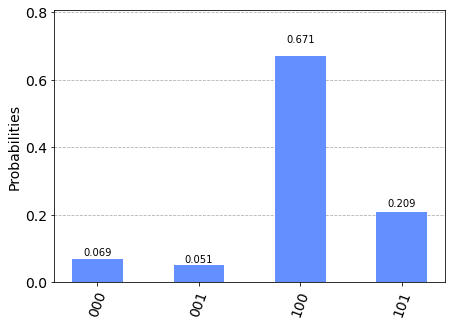

In [46]:
## Simulation of the circuit
simulator = Aer.get_backend('qasm_simulator')

shots = 1024

Sim_result_tomography_circuit=execute(tomography_circuit, backend=simulator,shots=shots).result()

Sim_result_counts_tomography_circuit=Sim_result_tomography_circuit.get_counts(tomography_circuit)

plot_histogram(Sim_result_counts_tomography_circuit).savefig('figures/test_circuit_nm.png',dpi=1200)

plot_histogram(Sim_result_counts_tomography_circuit)

In [47]:
## We build the vector P
p00_test = Sim_result_counts_tomography_circuit['000']/shots
p01_test = Sim_result_counts_tomography_circuit['001']/shots
p10_test = Sim_result_counts_tomography_circuit['100']/shots
p11_test = Sim_result_counts_tomography_circuit['101']/shots

p_test = [p00_test,p01_test,p10_test,p11_test]

U = U_matrix(angles_a,angles_b)
T = T_matrix(U)
s = np.array(np.matmul(np.linalg.inv(T),p_test))

s1=s[0,1].real
s2=s[0,2].real
s3=s[0,3].real

s_test = [s1,s2,s3]


For comparing the estimation with the initial state of the qubit $S$ we will calculate the fidelity between this quantum states and we are going to graph them in the bloch sphere. The fidelity will be defined as $\mathcal{F} (\rho_0^S,\rho_e^S) = Tr[\sqrt{\sqrt{\rho_0^S} \rho_e^S \sqrt{\rho_0^S}}]^2$, if the states are pure it can be reduced to $\mathcal{F}(\rho_0^S,\rho_e^S) = |\langle{\psi_0^S|\psi_e^S}\rangle|^2.$
First we have to transform the bloch vector into a qubit state of the form $|\psi\rangle = c_0|0\rangle + c_1 |1\rangle. $

In [48]:
def bloch_vector_to_state(s):
    ## We transform the bloch vector into a qubit state
    s1 = s[0]
    s2 = s[1]
    s3 = s[2]
    
    if (s3>0):
        th=np.arctan(np.sqrt(s1*s1 + s2*s2)/s3)
    elif (s3 == 0):
        th = pi/2
    elif (s3 < 0):
        th=np.arctan(np.sqrt(s1*s1 + s2*s2)/s3) + pi

    if (s1>0 and s2>0):
        phi = np.arctan(s2/s1)
    elif (s1>0 and s2<0):
        phi = np.arctan(s2/s1) + 2*pi
    elif (s1 == 0):
        phi = pi/2*np.sign(s2)
    elif (s1<0):
        phi = np.arctan(s2/s1) + pi

    ## We write the alpha and beta amplitudes
    c_0 = np.cos(th/2)
    c_1 = (np.cos(phi) + complex(0,1)*np.sin(phi))*np.sin(th/2)
    
    state = np.array([c_0,c_1])
    return state

def init_ang_to_bloch_vector(angles):
    
    th, phi, lam = angles
    
    s = np.array([np.sin(th)*np.cos(phi), np.sin(th)*np.sin(phi), np.cos(th)])
    
    return s

s_ideal = init_ang_to_bloch_vector(angle_i)


Now we find the $c_0$ and $c_1$ component of the initial state of the qubit $S$ from its initialization

In [49]:
## Initialize a 1 qubit circuit
qr = QuantumRegister(1)
cr = ClassicalRegister(1)

qc_i = QuantumCircuit(qr,cr)

## Use the U rotation that we used for initializing the qubit S
qc_i.u(angle_i[0],angle_i[1],angle_i[2],qr[0])

backend = BasicAer.get_backend('statevector_simulator') 
result = execute(qc_i, backend).result()

## Take the statevector
initial_state  = result.get_statevector(qc_i)
estim_state = bloch_vector_to_state(s_test)

## Calculate the fidelity
fidelity = quantum_info.state_fidelity(initial_state,estim_state)

print('The fidelity between the initial state and its estimation is: ',fidelity)

## Save the plots for visualzation
plot_bloch_vector(s_test, title="Estimated state").savefig("figures/estimation_test_nm.png")
plot_bloch_vector(s_ideal, title="Initial state").savefig("figures/initial_test_nm.png")

The fidelity between the initial state and its estimation is:  0.999493682880519


We now print the bloch spheres of these states
<table>
     <tr>
        <th style="text-align:center" >
            Initial state
        </th>
        <th style="text-align:center">
            Estimation
        </th>
     </tr> 
     <tr>
         <td><img width=350px src='figures/initial_test_nm.png'></td>
         <td><img width=350px src='figures/estimation_test_nm.png'></td>
    </tr>
</table>

As you can see, the estimation model works even for random values of the parameters $\vec{\theta}_{A_1},$ $\vec{\theta}_{A_2},$ $\vec{\theta}_{B_1},$ and $\vec{\theta}_{B_2}$. However, we are interested in finding the best set of parameters for the estimation. Then, we are going to introduce the Fisher error parameter which will be the criteria for finding the best set up for doing qubit state estimation.

## Fisher error
The Fisher information matrix can be defined in different ways. for the purposes of this model we define its components as 
$$F_{\mu\nu}(\mathbf{s}) =  \sum_{j=0}^{3}\frac{1}{p_j} \frac{\partial p_j}{\partial s_\mu} \frac{\partial p_j}{\partial s_\nu}.$$
The Fisher information matrix for this model can be written as
$$\mathbb{F} = \mathbb{D}^T\left(\mathbb{V}\mathbb{P}^{-1}\mathbb{V}^T\right)\mathbb{D},$$

this depends on the measurement matrix $\mathbb{D}$, and the auxiliary matrices $\mathbb{V}$ and  $\mathbb{P}$
$$
		\mathbb{D} = \begin{pmatrix}
			a_1&b_1&c_1\\
			a_2&b_2&c_2\\
			a_3&b_3&c_3
		\end{pmatrix}, \quad
		\mathbb{V} = \begin{pmatrix}
			1 & 1 & -1 & -1\\
			1 & -1 & 1 & -1\\
			1 & -1 & -1 & 1
		\end{pmatrix}, \quad 
		\mathbb{P} =  \begin{pmatrix}
			p_{00} & 0 & 0 & 0 \\
			0 & p_{01} & 0 & 0 \\
			0 & 0 & p_{10} & 0 \\
			0 & 0 & 0 & p_{11}
		\end{pmatrix}.
$$

To study the dependence of the error on the initial state of qubit $S$, we write $c_0= e^{i\alpha_2}\cos\alpha_1$ and $c_1  = e^{- i\alpha_2}\sin\alpha_1$, where $\alpha_1\in [0,\pi/2],$ and $\alpha_2\in [0,\pi]$.

We define the error measure as the trace of the inverse of the Fisher information matrix
$$\Delta (\alpha_1,\alpha_2,\vec{\theta}_{A_1},\vec{\theta}_{A_2}, \vec{\theta}_{B_1}, \vec{\theta}_{B_2})=  \operatorname{Tr}(\mathbb{F}^{-1}).$$

Now that we have parametrized the error of this model, we calculate the mean error over all the possible states, this is 
$$\bar{\Delta} = \frac{1}{V}\int^{\frac{\pi}{2}}_{0}\int^{\pi}_0 \Delta (\alpha_1,\alpha_2,\vec{\theta}_{A_1},\vec{\theta}_{A_2}, \vec{\theta}_{B_1}, \vec{\theta}_{B_2})\sin2\alpha_1d\alpha_1 d\alpha_2.$$

Here the integration Volume is $V = \pi$. Now that we have the mean error in terms of the angles $\vec{\theta}_{A_1},$ $\vec{\theta}_{A_2},$ $\vec{\theta}_{B_1},$ and $\vec{\theta}_{B_2}$, we can optimize this in order to find the best set of parameters that minimize the mean error of the estimation model.
To do so we define the objective function to ve optimized.

In [50]:
## We have to parametrized the tomography to find p_ij
def tomography_parametrized(alpha_params, U):
    
    
    c_0 = np.exp(( alpha_params[1])*j)*np.cos(alpha_params[0])
    c_1 =  np.exp((-alpha_params[1])*j)*np.sin(alpha_params[0])
    initial_state = c_0, c_1

    ## Definition of U_{ij}
    U_00 = np.matrix(np.array([[U[0,0],U[0,2]],[U[2,0],U[2,2]]]) + np.array([[U[0,1],U[0,3]],[U[2,1],U[2,3]]]) + np.array([[U[0,4],U[0,6]],[U[2,4],U[2,6]]]) + np.array([[U[0,5],U[0,7]],[U[2,5],U[2,7]]]))
    U_01 = np.matrix(np.array([[U[1,0],U[1,2]],[U[3,0],U[3,2]]]) + np.array([[U[1,1],U[1,3]],[U[3,1],U[3,3]]]) + np.array([[U[1,4],U[1,6]],[U[3,4],U[3,6]]]) + np.array([[U[1,5],U[1,7]],[U[3,5],U[3,7]]]))
    U_10 = np.matrix(np.array([[U[4,0],U[4,2]],[U[6,0],U[6,2]]]) + np.array([[U[4,1],U[4,3]],[U[6,1],U[6,3]]]) + np.array([[U[4,4],U[4,6]],[U[6,4],U[6,6]]]) + np.array([[U[4,5],U[4,7]],[U[6,5],U[6,7]]]))
    U_11 = np.matrix(np.array([[U[5,0],U[5,2]],[U[7,0],U[7,2]]]) + np.array([[U[5,1],U[5,3]],[U[7,1],U[7,3]]]) + np.array([[U[5,4],U[5,6]],[U[7,4],U[7,6]]]) + np.array([[U[5,5],U[5,7]],[U[7,5],U[7,7]]]))

    ## Their adjoints
    
    U_00d = U_00.getH()
    U_01d = U_01.getH()
    U_10d = U_10.getH()
    U_11d = U_11.getH()
    
    ## We define the Kraus operators
    E_00 = (U_00 + U_01 + U_10 + U_11)/4
    E_01 = (U_00 - U_01 + U_10 - U_11)/4
    E_10 = (U_00 + U_01 - U_10 - U_11)/4
    E_11 = (U_00 - U_01 - U_10 + U_11)/4

    ## And their adjoints
    E_00d = (U_00d + U_01d + U_10d + U_11d)/4
    E_01d = (U_00d - U_01d + U_10d - U_11d)/4
    E_10d = (U_00d + U_01d - U_10d - U_11d)/4
    E_11d = (U_00d - U_01d - U_10d + U_11d)/4


    ## The final states of the system are
    d_00 = np.matmul(E_00,initial_state)
    d_01 = np.matmul(E_01,initial_state)
    d_10 = np.matmul(E_10,initial_state)
    d_11 = np.matmul(E_11,initial_state)

    ## So the probabilities p_ij are
    P_00_teo =  d_00[0,0]*d_00[0,0].conjugate() + d_00[0,1]*d_00[0,1].conjugate()
    P_01_teo =  d_01[0,0]*d_01[0,0].conjugate() + d_01[0,1]*d_01[0,1].conjugate()
    P_10_teo =  d_10[0,0]*d_10[0,0].conjugate() + d_10[0,1]*d_10[0,1].conjugate()
    P_11_teo =  d_11[0,0]*d_11[0,0].conjugate() + d_11[0,1]*d_11[0,1].conjugate()

    p_teo = [P_00_teo.real,P_01_teo.real,P_10_teo.real,P_11_teo.real]


    return p_teo

## Definition of the measurement matrix
def D_matrix(U):
    
    ## Definition of U_{ij}
    U_00 = np.matrix(np.array([[U[0,0],U[0,2]],[U[2,0],U[2,2]]]) + np.array([[U[0,1],U[0,3]],[U[2,1],U[2,3]]]) + np.array([[U[0,4],U[0,6]],[U[2,4],U[2,6]]]) + np.array([[U[0,5],U[0,7]],[U[2,5],U[2,7]]]))
    U_01 = np.matrix(np.array([[U[1,0],U[1,2]],[U[3,0],U[3,2]]]) + np.array([[U[1,1],U[1,3]],[U[3,1],U[3,3]]]) + np.array([[U[1,4],U[1,6]],[U[3,4],U[3,6]]]) + np.array([[U[1,5],U[1,7]],[U[3,5],U[3,7]]]))
    U_10 = np.matrix(np.array([[U[4,0],U[4,2]],[U[6,0],U[6,2]]]) + np.array([[U[4,1],U[4,3]],[U[6,1],U[6,3]]]) + np.array([[U[4,4],U[4,6]],[U[6,4],U[6,6]]]) + np.array([[U[4,5],U[4,7]],[U[6,5],U[6,7]]]))
    U_11 = np.matrix(np.array([[U[5,0],U[5,2]],[U[7,0],U[7,2]]]) + np.array([[U[5,1],U[5,3]],[U[7,1],U[7,3]]]) + np.array([[U[5,4],U[5,6]],[U[7,4],U[7,6]]]) + np.array([[U[5,5],U[5,7]],[U[7,5],U[7,7]]]))

    ## Their adjoints
    U_00d = U_00.getH()
    U_01d = U_01.getH()
    U_10d = U_10.getH()
    U_11d = U_11.getH()
    
    A = 1/16*(np.matmul(U_00d,U_10) + np.matmul(U_01d,U_11) + np.matmul(U_10d,U_00) + np.matmul(U_11d,U_01))
    B = 1/16*(np.matmul(U_00d,U_01) + np.matmul(U_01d,U_00) + np.matmul(U_10d,U_11) + np.matmul(U_11d,U_10))
    C = 1/16*(np.matmul(U_00d,U_11) + np.matmul(U_01d,U_10) + np.matmul(U_10d,U_01) + np.matmul(U_11d,U_00))
    
    ## Pauli Matricez
    X = np.matrix([[0,1],[1,0]])
    Y = np.matrix([[0,-complex(0,1)],[complex(0,1),0]])
    Z = np.matrix([[1,0],[0,-1]])
    I = np.matrix([[1,0],[0,1]])

    ## D matrix components
    a0 = 0.5*np.trace(np.matmul(A,I))
    a1 = 0.5*np.trace(np.matmul(A,X))
    a2 = 0.5*np.trace(np.matmul(A,Y))
    a3 = 0.5*np.trace(np.matmul(A,Z))

    b0 = 0.5*np.trace(np.matmul(B,I))
    b1 = 0.5*np.trace(np.matmul(B,X))
    b2 = 0.5*np.trace(np.matmul(B,Y))
    b3 = 0.5*np.trace(np.matmul(B,Z))

    c0 = 0.5*np.trace(np.matmul(C,I))
    c1 = 0.5*np.trace(np.matmul(C,X))
    c2 = 0.5*np.trace(np.matmul(C,Y))
    c3 = 0.5*np.trace(np.matmul(C,Z))

    ## Definition of the D matrix
    D =np.matrix([[a1,a2,a3],[b1,b2,b3],[c1,c2,c3]])
    
    return D

## We now define the fisher error parameter
def error_parameter(D,p):
    
    ## Definition od the auxiliary matrix V
    V = np.matrix([[1,1,-1,-1],[1,-1,1,-1],[1,-1,-1,1]])

    ## Definition od the matrix P
    P = np.matrix([[p[0],0,0,0],[0,p[1],0,0],[0,0,p[2],0],[0,0,0,p[3]]])
    
    ## The Fisher information Matrix
    F = np.matmul(np.matmul(D.transpose(),(np.matmul(np.matmul(V,np.linalg.inv(P)),V.transpose()))),D)
    
    Error = np.abs(np.trace(np.linalg.inv(F)))
    return Error

## Definition of the integrand
def error_integrand(alpha_1,alpha_2,args):
    
    alpha_params = [alpha_1,alpha_2]
    th_a1,phi_a1,lam_a1,th_b1,phi_b1,lam_b1 = args[0],args[1],args[2],args[3],args[4],args[5]
    th_a2,phi_a2,lam_a2,th_b2,phi_b2,lam_b2 = args[6],args[7],args[8],args[9],args[10],args[11]
    
    angles_a=[th_a1,phi_a1,lam_a1,th_a2,phi_a2,lam_a2]
    
    angles_b=[th_b1,phi_b1,lam_b1,th_b2,phi_b2,lam_b2]
    

    U = U_matrix(angles_a,angles_b)
    D = D_matrix(U)
    deter = np.linalg.det(D)
    
    p = tomography_parametrized(alpha_params, U)
    error = error_parameter(D,p)*np.sin(2*alpha_1)
    
    return error.real

## Definition of the objective function
def obj_fn(params):
    
    bounds_1 = [0,pi/2]
    bounds_2 = [0,pi]
    
    I = nquad(error_integrand,[bounds_1,bounds_2],args=[params])

    return I[0]/pi

In [70]:
print(angles_a,angles_b)
error_integrand(0.2,pi/2,[pi, 0.06253904957851153, 0.2517388779631262, 0.2031922784084761, 0.2709473938942437, 0.7228748161484193,0.48760923377377896, 0.22272204721041655, 0.9234731076621223, 0.8673837693614859, 0.7872751767424359, 0.38009498437348277])

[2.69556689, 0.77107387, 3.04573265, 0.42102989, 5.30878105, 2.58689213] [2.42321458, 6.15305411, 1.39869662, 3.25541735, 3.26725694, 1.69725869]


86.39796559285811

In [53]:
def optimization(obj_fn, rep):
    
    results=[]
    params = []
    
    for i in range(rep):
        th_a1 = np.random.uniform(0,pi)
        phi_a1 = np.random.uniform(0,2*pi)
        lam_a1 = np.random.uniform(0,2*pi)

        th_b1 = np.random.uniform(0,pi)
        phi_b1 = np.random.uniform(0,2*pi)
        lam_b1 = np.random.uniform(0,2*pi)

        th_a2 = np.random.uniform(0,pi)
        phi_a2 = np.random.uniform(0,2*pi)
        lam_a2 = np.random.uniform(0,2*pi)

        th_b2 = np.random.uniform(0,pi)
        phi_b2 = np.random.uniform(0,2*pi)
        lam_b2 = np.random.uniform(0,2*pi)
        
        init = [th_a1,phi_a1,lam_a1,th_b1,phi_b1,lam_b1,th_a2,phi_a2,lam_a2,th_b2,phi_b2,lam_b2]
        res = minimize(obj_fn,init,method='nelder-mead', options={'xatol':1e-4, 'disp': True})
        
        results.append(res.fun)
        params.append(res.x)
    best = min(results)
    best_idx = results.index(best)
    print('results: ',results)
    print('parameters: ',params)
    
    print('best result: ', best)
    print('parameters best result: ',params[best_idx])
    return results, params

In [73]:
optimization(obj_fn, 5)

Optimization terminated successfully.
         Current function value: 8.000000
         Iterations: 384
         Function evaluations: 586
Optimization terminated successfully.
         Current function value: 8.000000
         Iterations: 450
         Function evaluations: 677
Optimization terminated successfully.
         Current function value: 8.000000
         Iterations: 428
         Function evaluations: 656
Optimization terminated successfully.
         Current function value: 8.000000
         Iterations: 403
         Function evaluations: 622
Optimization terminated successfully.
         Current function value: 8.000000
         Iterations: 340
         Function evaluations: 524
results:  [8.000000028736899, 8.000000002374689, 8.000000014319012, 8.000000006612005, 8.000000022918982]
parameters:  [array([2.3119275 , 3.29740455, 5.94407803, 1.50942699, 3.04676704,
       5.71040858, 1.05123399, 1.84174077, 3.00453519, 1.13370085,
       5.89563947, 2.33809697]), array([0.5871

([8.000000028736899,
  8.000000002374689,
  8.000000014319012,
  8.000000006612005,
  8.000000022918982],
 [array([2.3119275 , 3.29740455, 5.94407803, 1.50942699, 3.04676704,
         5.71040858, 1.05123399, 1.84174077, 3.00453519, 1.13370085,
         5.89563947, 2.33809697]),
  array([0.5871626 , 1.57737493, 2.52063619, 0.70004151, 4.30553732,
         3.45993977, 2.55283129, 1.93819982, 0.30976956, 0.67288561,
         6.47455126, 4.4695403 ]),
  array([0.20314671, 1.67305269, 3.65705772, 3.21719345, 1.12020446,
         5.83373307, 1.13180353, 3.51565745, 0.82514173, 0.33980707,
         4.91793247, 2.94746851]),
  array([0.91771471, 6.36317001, 6.48516248, 0.5079478 , 1.92315993,
         2.8307082 , 2.6440524 , 6.00929022, 4.40294593, 1.2242232 ,
         1.05601949, 6.4730176 ]),
  array([2.55725632, 2.50684312, 0.14725975, 2.1623159 , 0.92711311,
         2.74531372, 2.87791288, 1.36426916, 6.08359193, 0.90499616,
         3.37126466, 4.35061747])])

The code above can be used to find the optimal parameters, In this case we found that the best set of values are:
* $\vec{\theta}_{A_1} = (0.5871626,  1.57737493, 2.52063619)$.
* $\vec{\theta}_{A_2} = (0.5871626,  1.57737493, 2.52063619)$.
* $\vec{\theta}_{B_1} = (2.55283129, 1.93819982, 0.30976956)$.
* $\vec{\theta}_{B_2} = (0.67288561, 6.47455126, 4.4695403)$.

In [15]:
init = [3.45, -8.42]
minimize(obj_fn,init,method='nelder-mead', options={'xatol':1e-4, 'disp': True})

Optimization terminated successfully.
         Current function value: 16.993293
         Iterations: 28
         Function evaluations: 56


 final_simplex: (array([[ 3.41968803, -8.41648194],
       [ 3.41963129, -8.4164514 ],
       [ 3.41975718, -8.41644286]]), array([16.99329319, 16.99329327, 16.99329332]))
           fun: 16.99329319225016
       message: 'Optimization terminated successfully.'
          nfev: 56
           nit: 28
        status: 0
       success: True
             x: array([ 3.41968803, -8.41648194])

With the optimal values of the system we are now interested in the variation of the error for different initial states with the evolution operator parameters fixed. The plot that shows this behaviour is shown bellow.

In [74]:
def error_graph(alpha_1,alpha_2,args):
    
    alpha_params = [alpha_1,alpha_2]
    
    th_a1,phi_a1,lam_a1,th_b1,phi_b1,lam_b1 = args[0],args[1],args[2],args[3],args[4],args[5]
    th_a2,phi_a2,lam_a2,th_b2,phi_b2,lam_b2 = args[6],args[7],args[8],args[9],args[10],args[11]
    
    angles_a=[th_a1,phi_a1,lam_a1,th_a2,phi_a2,lam_a2]
    
    angles_b=[th_b1,phi_b1,lam_b1,th_b2,phi_b2,lam_b2]

    U = U_matrix(angles_a, angles_b)
    D = D_matrix(U)
    deter = np.linalg.det(D)
    
    p = tomography_parametrized(alpha_params, U)
    error = error_parameter(D,p)
    print(p,error.real)
    return error.real

alpha_1_range = np.linspace(0, pi/2, 40)
alpha_2_range = np.linspace(0, pi, 40)


th_a1,phi_a1,lam_a1,th_b1,phi_b1,lam_b1 = 0.5871626,  1.57737493, 2.52063619, 0.70004151, 4.30553732, 3.45993977
th_a2,phi_a2,lam_a2,th_b2,phi_b2,lam_b2 = 2.55283129, 1.93819982, 0.30976956, 0.67288561, 6.47455126, 4.4695403


params = [th_a1,phi_a1,lam_a1,th_b1,phi_b1,lam_b1, th_a2,phi_a2,lam_a2,th_b2,phi_b2,lam_b2]

Error = np.zeros((alpha_1_range.size, alpha_2_range.size))

x_i=-1
y_i=-1

for alpha_1 in alpha_1_range:
    x_i +=1
    y_i =-1
    for alpha_2 in alpha_2_range:
        y_i+=1
        error = error_graph(alpha_1,alpha_2, params)

        Error[y_i][x_i] = error

[0.39433824656653627, 0.10566175343443976, 0.3943382465649967, 0.1056617534340271] 8.00002274857037
[0.3943382465665364, 0.10566175343443977, 0.39433824656499683, 0.10566175343402712] 8.000022748570373
[0.39433824656653627, 0.10566175343443973, 0.39433824656499666, 0.10566175343402709] 8.00002274857037
[0.39433824656653627, 0.10566175343443975, 0.3943382465649967, 0.1056617534340271] 8.00002274857037
[0.39433824656653627, 0.10566175343443976, 0.3943382465649967, 0.10566175343402709] 8.00002274857037
[0.39433824656653627, 0.10566175343443973, 0.3943382465649968, 0.1056617534340271] 8.00002274857037
[0.39433824656653627, 0.10566175343443973, 0.39433824656499666, 0.10566175343402709] 8.00002274857037
[0.3943382465665362, 0.10566175343443973, 0.39433824656499666, 0.10566175343402709] 8.00002274857037
[0.3943382465665362, 0.10566175343443975, 0.3943382465649967, 0.1056617534340271] 8.00002274857037
[0.39433824656653627, 0.10566175343443975, 0.3943382465649967, 0.1056617534340271] 8.00002274

[0.398371474202042, 0.07532347166092813, 0.38656672353207, 0.1397383306049599] 8.000022454014337
[0.40346144397084793, 0.07668733114571419, 0.3814767537632639, 0.13837447112017376] 8.00002245401403
[0.4082667177754987, 0.07885002289179324, 0.3766714799586131, 0.13621177937409476] 8.000022454013706
[0.4126628415485481, 0.08175553431895155, 0.37227535618556384, 0.1333062679469364] 8.000022454013363
[0.41653595799345144, 0.0853286142074206, 0.36840223974066044, 0.1297331880584674] 8.000022454013015
[0.4197857554287404, 0.08947672166494158, 0.3651524423053717, 0.12558508060094647] 8.000022454012669
[0.42232806580788085, 0.09409242288726521, 0.36261013192623126, 0.12096937937862284] 8.000022454012335
[0.42409704462746706, 0.09905617363724958, 0.3608411531066448, 0.11600562862863842] 8.000022454012015
[0.4250468762652741, 0.10423941537780843, 0.3598913214688378, 0.1108223868880796] 8.000022454011729
[0.42515296058080587, 0.1095079048704928, 0.359785237153306, 0.10555389739539518] 8.000022454

[0.41104351941743544, 0.1730550772739476, 0.36277661201156974, 0.05312479129704678] 8.000021577966228
[0.4011119366395403, 0.17614989852613333, 0.37270819478946515, 0.05002997004486106] 8.000021577966551
[0.3908125328646056, 0.1776114998283671, 0.3830075985643997, 0.04856836874262724] 8.000021577966963
[0.3804120572403744, 0.17740202647466494, 0.393408074188631, 0.048777842096329446] 8.00002157796746
[0.3701798766223958, 0.17552690371485632, 0.40364025480660937, 0.050652964856138044] 8.00002157796803
[0.3603809991139588, 0.17203469624346374, 0.4134391323150467, 0.05414517232753069] 8.000021577968655
[0.3512692104954178, 0.16701585039962397, 0.42255092093358754, 0.05916401817137038] 8.000021577969314
[0.34308050130579115, 0.16060035165441428, 0.4307396301232143, 0.06557951691658018] 8.00002157797
[0.33602695481175915, 0.15295435805542903, 0.4377931766172465, 0.07322551051556543] 8.00002157797069
[0.33029125416245936, 0.1442758968206263, 0.443528877266546, 0.0819039717503681] 8.000021577

[0.38353215255347395, 0.2168829008759402, 0.37207809373999046, 0.027506852830595042] 8.000020143125933
[0.36826903118514676, 0.2165754902019959, 0.38734121510831776, 0.027814263504539458] 8.00002014312666
[0.353252889589565, 0.21382367121818013, 0.40235735670389944, 0.03056608248835512] 8.000020143127488
[0.3388726379464383, 0.20869871459071004, 0.41673760834702633, 0.035691039115825246] 8.000020143128408
[0.32550071721972496, 0.20133335400422114, 0.4301095290737396, 0.043056399702314146] 8.000020143129374
[0.3134834531323002, 0.19191834842905764, 0.44212679316116443, 0.052471405277477644] 8.000020143130381
[0.30313208651165, 0.18069754156414158, 0.4524781597818147, 0.06369221214239376] 8.000020143131394
[0.2947147123159265, 0.16796154641325545, 0.4608955339775379, 0.07642820729327984] 8.00002014313238
[0.2884493361153559, 0.15404021856089697, 0.46716091017810857, 0.09034953514563834] 8.000020143133327
[0.28449822786248224, 0.13929411308590522, 0.4711120184309824, 0.10509564062063007] 

[0.2498808930011998, 0.17577602014708363, 0.4808992757860874, 0.09344381106562896] 8.00001818665956
[0.24477334110607465, 0.1567139003203919, 0.4860068276812125, 0.1125059308923207] 8.000018186660693
[0.24278969950505663, 0.13707929890030227, 0.4879904692822307, 0.13214053231241035] 8.000018186661705
[0.24398134347365302, 0.11738074175001374, 0.48679882531363416, 0.1518390894626989] 8.000018186662572
[0.24831741005901903, 0.09812841115254262, 0.48246275872826816, 0.17109142006016997] 8.000018186663272
[0.2556855974142246, 0.07982093235757973, 0.47509457137306255, 0.18939889885513284] 8.000018186663786
[0.2658950733571006, 0.06293245944943851, 0.4648850954301865, 0.20628737176327402] 8.000018186664095
[0.2786814178235175, 0.04790039500533333, 0.4520987509637698, 0.22131943620737926] 8.0000181866642
[0.26232622975270836, 0.046248035601896775, 0.45375102168568393, 0.23767471295971085] 8.000017028155424
[0.2789191944775743, 0.03213398386504601, 0.4371580569608182, 0.25178876469656164] 8.00

[0.20280241219115586, 0.15297804889903455, 0.4971705726840884, 0.1470489662257213] 8.000015759224926
[0.20423300330763794, 0.12932955857023976, 0.4957399815676061, 0.170697456554516] 8.000015759225963
[0.20943853323182, 0.10621677165557047, 0.490534451643424, 0.1938102434691853] 8.000015759226802
[0.21828418147300477, 0.08423829719552846, 0.48168880340223935, 0.21578871792922738] 8.000015759227422
[0.23054085038815064, 0.06396336613386748, 0.4694321344870934, 0.23606364899088833] 8.000015759227797
[0.24589109869048728, 0.04591708853515343, 0.45408188618475687, 0.2541099265896024] 8.000015759227923
[0.22948261276847165, 0.04690970012382589, 0.45308919867774866, 0.27051848842995374] 8.000014388111174
[0.24886513973778113, 0.030422833974717664, 0.43370667170843935, 0.28700535457906207] 8.000014388111039
[0.2706413159997335, 0.01725864407914602, 0.41193049544648674, 0.3001695444746336] 8.000014388110635
[0.29424715002764357, 0.007758076040575573, 0.3883246614185768, 0.309670112513204] 8.00

[0.19717037470749726, 0.052831307362895014, 0.447167461473134, 0.30283085645647356] 8.000011375483885
[0.21884046665391788, 0.034398627974639, 0.42549736952671335, 0.32126353584472955] 8.000011375483732
[0.24318671121661983, 0.01968077380170896, 0.4011511249640113, 0.33598139001765953] 8.000011375483279
[0.26957855344992293, 0.00905892953625081, 0.37475928273070835, 0.3466032342831177] 8.000011375482543
[0.2973324585029811, 0.002808195365341875, 0.34700537767765005, 0.3528539684540266] 8.000011375481547
[0.3257296148133759, 0.001090462020649153, 0.3186082213672553, 0.35457170179871933] 8.000011375480334
[0.3540345509490076, 0.003950217893516376, 0.29030328523162363, 0.3517119459258522] 8.000011375478831
[0.3815141839318621, 0.011313396808996913, 0.2628236522487691, 0.34434876701037154] 8.000011375477186
[0.40745680570207027, 0.022989296300879706, 0.23688103047856096, 0.3326728675184888] 8.00001137547543
[0.4311905159828159, 0.03867551670539272, 0.2131473201978153, 0.31698664711397573] 

[0.36525571554550584, 0.01903410743502416, 0.2371098499721152, 0.37860032704735436] 8.000008068291793
[0.39326502407963126, 0.03164015296806048, 0.20910054143798978, 0.3659942815143181] 8.000008068289898
[0.41888945093213803, 0.048575996651710376, 0.18347611458548307, 0.34905843783066826] 8.000008068287901
[0.44146533690743817, 0.06940300903055668, 0.16090022861018288, 0.32823142545182193] 8.000008068285867
[0.46040797841733866, 0.09358178142391335, 0.1419575871002825, 0.3040526530584653] 8.000008068283847
[0.4752267709968444, 0.12048609632731702, 0.12713879452077664, 0.27714833815506157] 8.000008068281891
[0.48553791570210003, 0.14941914611695584, 0.11682764981552103, 0.24821528836542275] 8.000008068280053
[0.4910743593014344, 0.1796315800011098, 0.11129120621618668, 0.21800285448126883] 8.00000806827838
[0.4916927108137845, 0.21034091181204034, 0.11067285470383635, 0.18729352267033825] 8.000008068276909
[0.4873769552597861, 0.2407517859867141, 0.11498861025783494, 0.15688264849566447

[0.3535414503723181, 0.4066648871810153, 0.20420060884802463, 0.03559305359864201] 8.000004552185498
[0.32281250979025755, 0.4162404584164662, 0.23492954943008518, 0.026017482363191055] 8.000004552186486
[0.2909455079529441, 0.4207627445993864, 0.26679655126739854, 0.021495196180270786] 8.000004552187765
[0.2587657834689987, 0.42011462089308593, 0.2989762757513441, 0.022143319886571297] 8.000004552189308
[0.22710677429932377, 0.41431287336111405, 0.33063528492101885, 0.027945067418543145] 8.000004552191065
[0.1967884321517021, 0.4035077642170313, 0.3609536270686407, 0.03875017656262598] 8.000004552192989
[0.16859598616226462, 0.38797914011200657, 0.38914607305807813, 0.05427880066765062] 8.000004552195037
[0.14325960587332764, 0.3681291842535494, 0.4144824533470152, 0.07412875652610786] 8.000004552197153
[0.12143549022578645, 0.3444720000716919, 0.43630656899455644, 0.09778594070796542] 8.000004552199286
[0.10368887235123184, 0.31762029621019683, 0.454053186869111, 0.12463764456946039]

[0.26812505575151924, 0.44777469419146365, 0.243497986910727, 0.0406022631462898] 8.000000918260838
[0.235308222276399, 0.44711373863382514, 0.27631482038584737, 0.04126321870392835] 8.000000918262405
[0.20302241347692151, 0.44119712543484024, 0.3086006291853247, 0.04717983190291327] 8.000000918264195
[0.17210381484203874, 0.43017809176850885, 0.3395192278202076, 0.05819886556924468] 8.00000091826616
[0.1433532018356015, 0.41434202481875687, 0.36826984082664493, 0.07403493251899664] 8.000000918268253
[0.11751520023247453, 0.3940990704012799, 0.3941078424297718, 0.09427788693647371] 8.000000918270409
[0.09525900070210139, 0.36997351040235593, 0.41636404196014515, 0.11840344693539769] 8.000000918272585
[0.07716102712167483, 0.3425901841533835, 0.4344620155405716, 0.14578677318437017] 8.000000918274715
[0.06369000750050005, 0.31265830542041173, 0.4479330351617463, 0.17571865191734182] 8.000000918276749
[0.055194834170764595, 0.2809530941401323, 0.45642820849148175, 0.20742386319762107] 8.

[0.21223115978085816, 0.4690077247118023, 0.2529718143661242, 0.06578930114121528] 7.999997260614478
[0.18015473684052974, 0.463129483019804, 0.2850482373064525, 0.07166754283321347] 7.999997260616253
[0.14943665718223687, 0.45218191201515007, 0.31576631696474555, 0.08261511383786754] 7.999997260618212
[0.12087250293366444, 0.4364485480363661, 0.34433047121331795, 0.09834847781665138] 7.999997260620284
[0.09520207068579098, 0.4163368769461473, 0.37000090346119147, 0.11846014890687018] 7.999997260622427
[0.0730902111497789, 0.39236778046155585, 0.39211276299720355, 0.14242924539146185] 7.999997260624591
[0.05510960987278542, 0.36516204559115495, 0.41009336427419707, 0.1696349802618627] 7.999997260626706
[0.04172595498310963, 0.33542428657757356, 0.4234770191638727, 0.199372739275444] 7.999997260628723
[0.03328587611228376, 0.3039246957587377, 0.4319170980346987, 0.23087233009427993] 7.999997260630604
[0.03000796686969282, 0.2714790959908815, 0.4351950072772897, 0.2633179298621362] 7.999

[0.1590960052031931, 0.4795419095750922, 0.2605881038625629, 0.1007739813591515] 7.999993673978398
[0.12937402664917524, 0.4689493375706417, 0.2903100824165809, 0.11136655336360207] 7.999993673980289
[0.1017361277494461, 0.4537261624255208, 0.31794798131630997, 0.12658972850872302] 7.9999936739822965
[0.07689811556798848, 0.43426665637962225, 0.3427859934977676, 0.1460492345546216] 7.999993673984377
[0.05550328157349495, 0.4110748104179267, 0.3641808274922612, 0.16924108051631703] 7.999993673986463
[0.03810574072823345, 0.38475128116872614, 0.3815783683375227, 0.1955646097655177] 7.99999367398851
[0.025156080201588868, 0.355977834212461, 0.39452802886416727, 0.2243380567217827] 7.999993673990468
[0.016989689399057605, 0.3254996867113029, 0.40269441966669856, 0.2548162042229409] 7.999993673992274
[0.013818073552817568, 0.29410620667609744, 0.4058660355129386, 0.2862096842581464] 7.999993673993902
[0.015723375847313256, 0.26261046874952043, 0.4039607332184429, 0.3177054221847234] 7.99999

[0.04295370421128626, 0.4256100980219497, 0.3332916579029257, 0.19814453986383831] 7.999990251250251
[0.026589810967141442, 0.4008505399743899, 0.34965555114707053, 0.2229040979113981] 7.999990251252177
[0.014409534209024489, 0.3737866222376124, 0.3618358279051875, 0.24996801564817567] 7.99999025125401
[0.006728336706965741, 0.34511928606497777, 0.3695170254072463, 0.27863535182081023] 7.999990251255713
[0.003745157441521128, 0.3155910004050987, 0.37250020467269085, 0.3081636374806894] 7.999990251257246
[0.005537259188673691, 0.2859665323460715, 0.3707081029255383, 0.3377881055397165] 7.99999025125855
[0.012058227454519937, 0.25701314004960785, 0.36418713465969205, 0.36674149783618015] 7.999990251259595
[0.023139172586281412, 0.22948070116766917, 0.3531061895279305, 0.3942739367181188] 7.999990251260367
[0.038493103925598134, 0.20408229140517314, 0.3377522581886138, 0.4196723464806148] 7.9999902512608365
[0.05772236271583076, 0.18147571623379782, 0.31852299939838125, 0.4422789216519901

[0.0016825884779326497, 0.30839109227598144, 0.3343291855431385, 0.3555971337029473] 7.999987081070545
[0.007622761250233534, 0.28201645808461556, 0.32838901277083754, 0.38197176789431303] 7.999987081071532
[0.017716772734355925, 0.25693621890324825, 0.31829500128671523, 0.40705200707568057] 7.9999870810722316
[0.03170319333500126, 0.23379993975263333, 0.3043085806860699, 0.43018828622629535] 7.99998708107266
[0.04921978210534148, 0.21320683810984375, 0.2867919919157297, 0.450781387869085] 7.99998708107281
[0.0469099805516245, 0.229482332340673, 0.27051656646161426, 0.45309112064608803] 7.999985616657723
[0.06629250752093388, 0.21299546619156476, 0.2511340394923049, 0.4695779867951963] 7.99998561665759
[0.08806868378288638, 0.19983127629599307, 0.22935786323035234, 0.48274217669076774] 7.999985616657182
[0.11167451781079632, 0.19033070825742263, 0.20575202920244232, 0.49224274472933827] 7.99998561665652
[0.13649863090291492, 0.1847398217976337, 0.18092791611032372, 0.4978336311891274] 

[0.018310375827099816, 0.2842121028414334, 0.2817149977571151, 0.41576252357435156] 7.999984245539025
[0.03056704474224569, 0.2639371717797724, 0.2694583288419693, 0.4360374546360125] 7.999984245539405
[0.04591729304458234, 0.2458908941810584, 0.25410808053963263, 0.45408373223472653] 7.999984245539535
[0.046248157543623755, 0.2623261078109812, 0.23767294947744294, 0.45375278516795176] 7.999982976610456
[0.06284112226848965, 0.24821205607413055, 0.22107998475257712, 0.4678668369048025] 7.999982976610342
[0.08148323870300701, 0.2369424760593818, 0.20243786831805965, 0.4791364169195511] 7.999982976609991
[0.10169168582377505, 0.22880924396947933, 0.18222942119729163, 0.4872696490094536] 7.9999829766094255
[0.12294307546537456, 0.2240230062433612, 0.16097803155569207, 0.49205588673557155] 7.999982976608653
[0.14468700779892935, 0.22270772392403906, 0.13923409922213725, 0.49337116905489375] 7.999982976607695
[0.16636032639856252, 0.22489746213269735, 0.11756078062250418, 0.4911814308462356

[0.04790042826550929, 0.27868138456334157, 0.22131776140666246, 0.4521004257644865] 7.999981818099997
[0.05086338960057908, 0.2948506541923637, 0.20514858599793218, 0.44913737020912475] 7.999980777521518
[0.06423704301051066, 0.2834749633939847, 0.19177493258800063, 0.46051306100750383] 7.999980777521429
[0.07926227859419205, 0.2743918694628029, 0.1767496970043192, 0.46959615493868534] 7.999980777521147
[0.09554995064239896, 0.26783661976050677, 0.16046202495611223, 0.47615140464098166] 7.99998077752069
[0.11267821700460322, 0.2639789918110711, 0.14333375859390796, 0.4800090325904173] 7.9999807775200695
[0.130203464579088, 0.26291889615206787, 0.12580851101942322, 0.4810691282494207] 7.999980777519302
[0.147671798659263, 0.2646837887042225, 0.10834017693924819, 0.47930423569726605] 7.999980777518397
[0.1646307985681453, 0.26922795967748936, 0.09138117703036583, 0.4747600647239989] 7.999980777517387
[0.18064123511624758, 0.2764337174306045, 0.07537074048226357, 0.46755430697088396] 7.99

[0.13163350695541137, 0.3040898234901195, 0.10278847763401303, 0.46148819192045576] 7.999979076343875
[0.14407090028523745, 0.3074224281281382, 0.09035108430418691, 0.458155587282437] 7.999979076343134
[0.15581263610697527, 0.3127069875889821, 0.07860934848244909, 0.45287102782159294] 7.999979076342335
[0.1665546096304917, 0.3198066345584668, 0.06786737495893266, 0.4457713808521084] 7.999979076341502
[0.17601860938402675, 0.32853749190935533, 0.05840337520539762, 0.4370405235012198] 7.9999790763406455
[0.18395952274517413, 0.33867343502236835, 0.0504624618442503, 0.426904580388207] 7.999979076339803
[0.19017168422904987, 0.3499519482950443, 0.044250300360374584, 0.4156260671155311] 7.999979076338986
[0.19449420211631982, 0.36208092415795123, 0.03992778247310454, 0.40349709125262395] 7.999979076338215
[0.19681512546421803, 0.3747462285072981, 0.037606859125206366, 0.39083178690327713] 7.999979076337509
[0.19707434357715864, 0.3876198366132146, 0.037347641012265696, 0.3779581787973605] 7

[0.1457602099342153, 0.35702152294891315, 0.0739500934860261, 0.4232681736308451] 7.999977917140566
[0.15060854371639976, 0.3632100346696882, 0.06910175970384161, 0.41707966191007] 7.999977917140052
[0.15440138605239875, 0.37009614391503964, 0.0653089173678426, 0.4101935526647187] 7.999977917139551
[0.15704050431799838, 0.37750150407261934, 0.062669799102243, 0.4027881925071391] 7.999977917139079
[0.15845754673638454, 0.38523432020420256, 0.06125275668385681, 0.3950553763755557] 7.999977917138649
[0.1586158126532592, 0.39309431643384296, 0.06109449076698212, 0.3871953801459152] 7.999977917138276
[0.1575112030645086, 0.4008779229878588, 0.06219910035573274, 0.3794117735918995] 7.999977917137965
[0.15517232677825665, 0.40838354854504133, 0.06453797664198471, 0.371906148034717] 7.999977917137718
[0.15165975946176205, 0.41541680134598313, 0.06805054395847934, 0.36487289523377514] 7.9999779171375565
[0.1470644747634553, 0.4217955238375377, 0.07264582865678604, 0.35849417274222056] 7.9999779

[0.12136624924554344, 0.40000353122592536, 0.09089170766000987, 0.3877385118685208] 7.999977329935476
[0.12018519726473698, 0.4023683648087746, 0.09207275964081635, 0.3853736782856717] 7.999977329935422
[0.11864009660009801, 0.4045131216646186, 0.0936178603054553, 0.3832289214298276] 7.999977329935392
[0.11677096454723676, 0.40638225371747994, 0.09548699235831658, 0.38135978937696635] 7.999977329935392
[0.11462621064451237, 0.40792735142899916, 0.09763174626104099, 0.379814691665447] 7.999977329935421
[0.11226138289141802, 0.4091083975800508, 0.09999657401413528, 0.3786336455143955] 7.999977329935476
[0.10973772908457205, 0.4098948036956972, 0.10252022782098127, 0.37784723939874887] 7.999977329935554
[0.1071206105319574, 0.4102662022706236, 0.1051373463735959, 0.3774758408238225] 7.999977329935659
[0.10447780922937773, 0.4102129742768259, 0.10778014767617561, 0.3775290688176203] 7.999977329935788
[0.10187777234237014, 0.4097364982913841, 0.11038018456318319, 0.37800554480306203] 7.9999

In [75]:
Error[0,20]

7.999999086490503

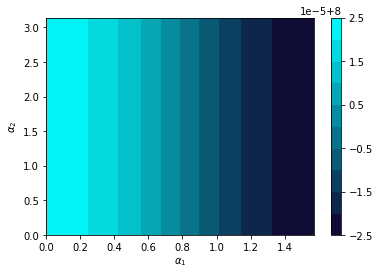

In [76]:
X, Y = np.meshgrid(alpha_1_range, alpha_2_range)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#10002b","cyan"])

plt.contourf(X, Y, Error, 10,linestyles='solid', cmap=cmap)
plt.xlabel(r'$\alpha_1$')
plt.ylabel(r'$\alpha_2$')
#plt.plot(th_a,th_b,'bo',color='white') 

plt.colorbar()

plt.savefig('figures/error_v_init_nm.png')

As you can see, the variation of the error is lower than for the Saavedra model; here, the variation is of $\pm2.5\times10^{-5}$ around the mean value which is approximatelly $\bar{\Delta}\approx 8$. The Saavedra model has a mean value of the QTTF error of $\bar{\Delta} \approx 17$. But this error has a variation of $\pm 6$ around this mean value for different initial states.

### Simulation in a quantum device
Now that we have found the best set of parameters $\vec{\theta}_{A_1},$ $\vec{\theta}_{A_2},$ $\vec{\theta}_{B_1},$ and $\vec{\theta}_{B_2}$. For this set of values, the mean error takes an approximate value of $\bar{\Delta} \approx 8.$ We are going to execute the model in a local simulator for the six eigenstates of the Pauli matrices, this is,  $X= \left\{|{\psi_{z_0}}\rangle,|{\psi_{z_1}}\rangle,|{\psi_{x_0}}\rangle,|{\psi_{x_1}}\rangle,|{\psi_{y_0}}\rangle,|{\psi_{y_1}}\rangle\right\} = \left\{|0\rangle, |1\rangle, \frac{|0\rangle+|1\rangle}{\sqrt{2}}, \frac{|0\rangle-|1\rangle}{\sqrt{2}}, \frac{|0\rangle+i|1\rangle}{\sqrt{2}}, \frac{|0\rangle-i|1\rangle}{\sqrt{2}}\right\}.$ 

After this, we are going to compare the performance of the model in a real quantum computer, in this case we are going to use the `ibmq_lima` Quantum procesing unit (QPU).

In [77]:
def tg_circuit(angles_i):
    ## We define the tomography circuit as a function
    A = QuantumRegister(1,'a')
    S = QuantumRegister(1,'s')
    B = QuantumRegister(1,'b')
    cr = ClassicalRegister(3)
    
    ## We use the best values of the angles for A and B
    th_a1,phi_a1,lam_a1,th_b1,phi_b1,lam_b1 = 0.5871626,  1.57737493, 2.52063619, 0.70004151, 4.30553732, 3.45993977
    th_a2,phi_a2,lam_a2,th_b2,phi_b2,lam_b2 = 2.55283129, 1.93819982, 0.30976956, 0.67288561, 6.47455126, 4.4695403
    
    angles_a=[th_a1,phi_a1,lam_a1,th_a2,phi_a2,lam_a2]
    
    angles_b=[th_b1,phi_b1,lam_b1,th_b2,phi_b2,lam_b2]
    
    tomography_circuit = QuantumCircuit(A,S,B, cr)

    tomography_circuit.append(Initialization(angles_i),[A,S,B])
    tomography_circuit.barrier()

    tomography_circuit.append(U_operator(angles_a,angles_b),[A,S,B])
    tomography_circuit.barrier()

    tomography_circuit.h(A)                     #A
    tomography_circuit.h(B)                     #B
    tomography_circuit.barrier()

    tomography_circuit.measure(A,cr[0])         #A
    tomography_circuit.measure(B,cr[2])         #B
    
    tomography_circuit=transpile(tomography_circuit, basis_gates=['cx','id','rz','sx','x'], optimization_level=3)
    
    return tomography_circuit

def IBM_sim_probs(angles_i, device=0):
    circuit = tg_circuit(angles_i)
    
    shots = 1024
    ## Local simulator
    simulator = Aer.get_backend('qasm_simulator')
    
    ## Quantum simulator
    qcom = provider.get_backend('ibmq_lima') #ibmqx2

    %qiskit_job_watcher
    if device == 0:
        job=execute(circuit, backend=simulator,shots = shots)
    else:
        job=execute(circuit, backend=qcom)

    job_monitor(job)
    sim_result=job.result()
    
    sim_result_counts = sim_result.get_counts(circuit)
    
    if '000' in sim_result_counts:
        p00 = sim_result_counts['000']/shots
    else:
        p00 = 0

    if '001' in sim_result_counts:
        p01 = sim_result_counts['001']/shots
    else:
        p01 = 0
    if '100' in sim_result_counts:
        p10 = sim_result_counts['100']/shots
    else:
        p10 = 0
    if '101' in sim_result_counts:
        p11 = sim_result_counts['101']/shots
    else:
        p11 = 0


    p = [p00,p01,p10,p11]

    return p

def ideal_prob(angles_i):
    
    ## Here we calculate the ideal probabilities of the experiment
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)

    qc_i = QuantumCircuit(qr,cr)
    
    qc_i.u(angles_i[0],angles_i[1],angles_i[2],qr[0])
    
    backend = BasicAer.get_backend('statevector_simulator') 
    result = execute(qc_i, backend).result()
    
    th_a1,phi_a1,lam_a1,th_b1,phi_b1,lam_b1 = 0.5871626,  1.57737493, 2.52063619, 0.70004151, 4.30553732, 3.45993977
    th_a2,phi_a2,lam_a2,th_b2,phi_b2,lam_b2 = 2.55283129, 1.93819982, 0.30976956, 0.67288561, 6.47455126, 4.4695403
    
    angles_a=[th_a1,phi_a1,lam_a1,th_a2,phi_a2,lam_a2]
    
    angles_b=[th_b1,phi_b1,lam_b1,th_b2,phi_b2,lam_b2]
    
    U = U_matrix(angles_a, angles_b)
    
    ## Tomamos el estado asociado
    initial_state  = result.get_statevector(qc_i)
    alpha,beta = initial_state[0],initial_state[1]

    ## Se definen los operadores U_{ij}
    U_00 = np.matrix(np.array([[U[0,0],U[0,2]],[U[2,0],U[2,2]]]) + np.array([[U[0,1],U[0,3]],[U[2,1],U[2,3]]]) + np.array([[U[0,4],U[0,6]],[U[2,4],U[2,6]]]) + np.array([[U[0,5],U[0,7]],[U[2,5],U[2,7]]]))
    U_01 = np.matrix(np.array([[U[1,0],U[1,2]],[U[3,0],U[3,2]]]) + np.array([[U[1,1],U[1,3]],[U[3,1],U[3,3]]]) + np.array([[U[1,4],U[1,6]],[U[3,4],U[3,6]]]) + np.array([[U[1,5],U[1,7]],[U[3,5],U[3,7]]]))
    U_10 = np.matrix(np.array([[U[4,0],U[4,2]],[U[6,0],U[6,2]]]) + np.array([[U[4,1],U[4,3]],[U[6,1],U[6,3]]]) + np.array([[U[4,4],U[4,6]],[U[6,4],U[6,6]]]) + np.array([[U[4,5],U[4,7]],[U[6,5],U[6,7]]]))
    U_11 = np.matrix(np.array([[U[5,0],U[5,2]],[U[7,0],U[7,2]]]) + np.array([[U[5,1],U[5,3]],[U[7,1],U[7,3]]]) + np.array([[U[5,4],U[5,6]],[U[7,4],U[7,6]]]) + np.array([[U[5,5],U[5,7]],[U[7,5],U[7,7]]]))

    ## Y sus adjuntos dado que los necesitaremos luego
    U_00d = U_00.getH()
    U_01d = U_01.getH()
    U_10d = U_10.getH()
    U_11d = U_11.getH()
    
    ## Definimos los operadores de Kraus
    E_00 = (U_00 + U_01 + U_10 + U_11)/4
    E_01 = (U_00 - U_01 + U_10 - U_11)/4
    E_10 = (U_00 + U_01 - U_10 - U_11)/4
    E_11 = (U_00 - U_01 - U_10 + U_11)/4

    ## Y sus conjugados
    E_00d = (U_00d + U_01d + U_10d + U_11d)/4
    E_01d = (U_00d - U_01d + U_10d - U_11d)/4
    E_10d = (U_00d + U_01d - U_10d - U_11d)/4
    E_11d = (U_00d - U_01d - U_10d + U_11d)/4


    ## Los estados finales del sistema son
    d_00 = np.matmul(E_00,initial_state)
    d_01 = np.matmul(E_01,initial_state)
    d_10 = np.matmul(E_10,initial_state)
    d_11 = np.matmul(E_11,initial_state)


    P_00_teo =  d_00[0,0]*d_00[0,0].conjugate() + d_00[0,1]*d_00[0,1].conjugate()
    P_01_teo =  d_01[0,0]*d_01[0,0].conjugate() + d_01[0,1]*d_01[0,1].conjugate()
    P_10_teo =  d_10[0,0]*d_10[0,0].conjugate() + d_10[0,1]*d_10[0,1].conjugate()
    P_11_teo =  d_11[0,0]*d_11[0,0].conjugate() + d_11[0,1]*d_11[0,1].conjugate()

    p_teo = [P_00_teo.real,P_01_teo.real,P_10_teo.real,P_11_teo.real]


    return p_teo 

def bloch_vector_from_prob(p):
    ## best angles
    th_a1,phi_a1,lam_a1,th_b1,phi_b1,lam_b1 = 0.5871626,  1.57737493, 2.52063619, 0.70004151, 4.30553732, 3.45993977
    th_a2,phi_a2,lam_a2,th_b2,phi_b2,lam_b2 = 2.55283129, 1.93819982, 0.30976956, 0.67288561, 6.47455126, 4.4695403
    
    angles_a=[th_a1,phi_a1,lam_a1,th_a2,phi_a2,lam_a2]
    
    angles_b=[th_b1,phi_b1,lam_b1,th_b2,phi_b2,lam_b2]
    
    U = U_matrix(angles_a, angles_b)
    T = T_matrix(U)
    s = np.array(np.matmul(np.linalg.inv(T),p))
    
    s1=s[0,1].real
    s2=s[0,2].real
    s3=s[0,3].real

    s = [s1,s2,s3]
    
    return s

In [78]:
## Initial angles for Pauli matrices eigenstates 
ang_z0 = [0,0,0]
ang_z1 = [pi,0,0]
ang_x0 = [pi/2,0,0]
ang_x1 = [-pi/2,0,0]
ang_y0 = [-pi/2,-pi/2,pi/2]
ang_y1 = [pi/2,-pi/2,pi/2]

## We recalculate the T matrix
th_a1,phi_a1,lam_a1,th_b1,phi_b1,lam_b1 = 0.5871626,  1.57737493, 2.52063619, 0.70004151, 4.30553732, 3.45993977
th_a2,phi_a2,lam_a2,th_b2,phi_b2,lam_b2 = 2.55283129, 1.93819982, 0.30976956, 0.67288561, 6.47455126, 4.4695403

angles_a=[th_a1,phi_a1,lam_a1,th_a2,phi_a2,lam_a2]

angles_b=[th_b1,phi_b1,lam_b1,th_b2,phi_b2,lam_b2]

U = U_matrix(angles_a, angles_b)
T = np.array(T_matrix(U))

In [89]:
## File where the results will be stored
file = open("NM_data_s_sim.txt","a")

## IBMQ provider
provider=IBMQ.get_provider('ibm-q')

angles = [ang_z0,ang_z1,ang_x0,ang_x1,ang_y0,ang_y1]
states=['z0','z1','x0','x1','y0','y1']

state = 0
for a_i in angles:
    
    for n in range(5):
        
        p_ideal = ideal_prob(a_i)
        p_IBM = IBM_sim_probs(a_i,0)

        s_real = bloch_vector_from_prob(p_ideal)
        s_IBM = bloch_vector_from_prob(p_IBM)
        
        ideal_state = bloch_vector_to_state(s_real)
        rec_IBM_state = bloch_vector_to_state(s_IBM)
        
        fidelity_ibm = quantum_info.state_fidelity(ideal_state,rec_IBM_state)
        
        file.write("%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s  \n" % 
                   (states[state], p_ideal[0], p_ideal[1],p_ideal[2], p_ideal[3],  p_IBM[0], p_IBM[1],p_IBM[2], p_IBM[3], s_real[0],s_real[1],s_real[2], s_IBM[0],s_IBM[1],s_IBM[2], fidelity_ibm))
        
        print('s ideal: ', s_real)
        print('s simulation: ', s_IBM)
        print('Local simulation fidelity: ',fidelity_ibm)
        
        print('State: ', states[state], 'run: ',n+1,' Finished.')
    state += 1
file.close()    

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.7174568604417033e-16, 1.8804018555025551e-16, 0.9999999999999998]
s simulation:  [0.05412695192107052, -0.006765562465313374, 0.9066163434626417]
Local simulation fidelity:  0.9990974408539745
State:  z0 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.7174568604417033e-16, 1.8804018555025551e-16, 0.9999999999999998]
s simulation:  [0.0913392313644818, 0.013532107864217394, 1.004720043116829]
Local simulation fidelity:  0.997901768643001
State:  z0 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.7174568604417033e-16, 1.8804018555025551e-16, 0.9999999999999998]
s simulation:  [-0.010148803481185215, -0.016914622537099223, 0.9878056121419692]
Local simulation fidelity:  0.9999003375922969
State:  z0 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.7174568604417033e-16, 1.8804018555025551e-16, 0.9999999999999998]
s simulation:  [-0.10148803484228548, -0.047361302958948824, 1.008102929311801]
Local simulation fidelity:  0.9969427482972879
State:  z0 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.7174568604417033e-16, 1.8804018555025551e-16, 0.9999999999999998]
s simulation:  [-0.0033829344914740513, -0.02368041824117132, 1.0825264256011842]
Local simulation fidelity:  0.9998779727744399
State:  z0 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-3.604798013527443e-16, -1.568856821800491e-16, -1.0]
s simulation:  [-0.003382934491474421, -0.09472162299558634, -0.9438224051870236]
Local simulation fidelity:  0.997497687578115
State:  z1 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-3.604798013527443e-16, -1.568856821800491e-16, -1.0]
s simulation:  [0.00338293449823672, 0.043977905312915525, -0.9877999257216592]
Local simulation fidelity:  0.9995022806697882
State:  z1 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-3.604798013527443e-16, -1.568856821800491e-16, -1.0]
s simulation:  [0.0981051003541925, -0.027062832963321265, -1.0520747634261265]
Local simulation fidelity:  0.9976770156096754
State:  z1 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-3.604798013527443e-16, -1.568856821800491e-16, -1.0]
s simulation:  [-0.027063475955463406, -0.05412676547106039, -0.9472052913819956]
Local simulation fidelity:  0.9989826754883601
State:  z1 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-3.604798013527443e-16, -1.568856821800491e-16, -1.0]
s simulation:  [-0.016914672470896758, -0.027063399396418185, -1.031777446256295]
Local simulation fidelity:  0.9997609813087386
State:  z1 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.9999999999999996, -2.220446049250313e-16, 0.0]
s simulation:  [0.899860575634962, 0.020301918577942446, 0.04059747754981857]
Local simulation fidelity:  0.9993651120445096
State:  x0 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.9999999999999996, -2.220446049250313e-16, 0.0]
s simulation:  [0.9911998069960624, 0.03045111192824551, 0.027065932769930745]
Local simulation fidelity:  0.9995781746921647
State:  x0 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.9999999999999996, -2.220446049250313e-16, 0.0]
s simulation:  [0.8930947066452508, 0.0338335433059998, 0.013534387990042807]
Local simulation fidelity:  0.9995843146933484
State:  x0 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.9999999999999996, -2.220446049250313e-16, 0.0]
s simulation:  [0.9878168725012066, 0.01015360819689426, 0.030448818964902702]
Local simulation fidelity:  0.9997362599718621
State:  x0 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.9999999999999996, -2.220446049250313e-16, 0.0]
s simulation:  [0.9506045930577955, 0.0067705104272277605, 0.05074613613473444]
Local simulation fidelity:  0.9992764552399596
State:  x0 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999998, 5.551115123125783e-17, -2.220446049250313e-16]
s simulation:  [-1.004731544968722, 0.016909624599587003, 2.8432101548681032e-06]
Local simulation fidelity:  0.9999292028736956
State:  x1 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999998, 5.551115123125783e-17, -2.220446049250313e-16]
s simulation:  [-0.987816872494444, 0.010143878874717904, -0.0033800429848169777]
Local simulation fidelity:  0.9999707124889932
State:  x1 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999998, 5.551115123125783e-17, -2.220446049250313e-16]
s simulation:  [-1.0250291519378556, 0.016909524640665974, -0.06765488068928438]
Local simulation fidelity:  0.9988468715441884
State:  x1 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999998, 5.551115123125783e-17, -2.220446049250313e-16]
s simulation:  [-1.0148803484532887, -0.050748715618240736, 0.05074613613473444]
Local simulation fidelity:  0.9987545013751796
State:  x1 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999998, 5.551115123125783e-17, -2.220446049250313e-16]
s simulation:  [-1.0453267589069888, -0.08796092518762993, 0.04398036374479053]
Local simulation fidelity:  0.9978018678652264
State:  x1 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.0, 0.9999999999999998, 0.0]
s simulation:  [-0.027063475955463545, 1.0081083912757605, 0.006768615600099004]
Local simulation fidelity:  0.9998086656075058
State:  y0 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.0, 0.9999999999999998, 0.0]
s simulation:  [-0.10148803484228613, 1.0453200843911632, -0.11163240122391982]
Local simulation fidelity:  0.9948722905645938
State:  y0 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.0, 0.9999999999999998, 0.0]
s simulation:  [-0.06427575539887487, 1.0351715241131099, -0.13869549078369559]
Local simulation fidelity:  0.994635855204601
State:  y0 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.0, 0.9999999999999998, 0.0]
s simulation:  [-0.020297606965752446, 1.0487033987384364, -0.013528701569732737]
Local simulation fidelity:  0.9998647961596565
State:  y0 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.0, 0.9999999999999998, 0.0]
s simulation:  [-0.01691467247089684, 0.9878109541835753, -0.0033800429848169777]
Local simulation fidelity:  0.9999237877102466
State:  y0 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-1.1102230246251565e-16, -0.9999999999999999, -1.1102230246251565e-16]
s simulation:  [0.0033829344982372334, -1.055469311061327, -0.010145815374761002]
Local simulation fidelity:  0.999974333164241
State:  y1 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-1.1102230246251565e-16, -0.9999999999999999, -1.1102230246251565e-16]
s simulation:  [-0.006765868986329526, -0.8964723789801308, 0.01015150179507085]
Local simulation fidelity:  0.9999537090315255
State:  y1 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-1.1102230246251565e-16, -0.9999999999999999, -1.1102230246251565e-16]
s simulation:  [0.06089282091078185, -1.0757665149161666, 0.06766056710959434]
Local simulation fidelity:  0.9982195961160871
State:  y1 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-1.1102230246251565e-16, -0.9999999999999999, -1.1102230246251565e-16]
s simulation:  [0.010148803487948332, -1.035171790670224, -0.03720890493453677]
Local simulation fidelity:  0.9996533266101384
State:  y1 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-1.1102230246251565e-16, -0.9999999999999999, -1.1102230246251565e-16]
s simulation:  [-0.08457336236800755, -0.9979601975131609, 0.07442633949953825]
Local simulation fidelity:  0.9968441637048244
State:  y1 run:  5  Finished.


In [80]:
## File where the results will be stored
file = open("NM_data_s_qpu.txt","a")

## IBMQ provider
provider=IBMQ.get_provider('ibm-q')

angles = [ang_z0,ang_z1,ang_x0,ang_x1,ang_y0,ang_y1]
states=['z0','z1','x0','x1','y0','y1']

state = 0
for a_i in angles:
    
    for n in range(5):
        
        p_ideal = ideal_prob(a_i)
        p_IBM = IBM_sim_probs(a_i, 1)

        s_real = bloch_vector_from_prob(p_ideal)
        s_IBM = bloch_vector_from_prob(p_IBM)
        
        ideal_state = bloch_vector_to_state(s_real)
        rec_IBM_state = bloch_vector_to_state(s_IBM)
        
        fidelity_ibm = quantum_info.state_fidelity(ideal_state,rec_IBM_state)
        
        file.write("%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s  \n" % 
                   (states[state], p_ideal[0], p_ideal[1],p_ideal[2], p_ideal[3],  p_IBM[0], p_IBM[1],p_IBM[2], p_IBM[3], s_real[0],s_real[1],s_real[2], s_IBM[0],s_IBM[1],s_IBM[2], fidelity_ibm))
        
        print('s ideal: ', s_real)
        print('s simulation: ', s_IBM)
        print('QPU simulation fidelity: ',fidelity_ibm)
        
        print('State: ', states[state], 'run: ',n+1,' Finished.')
    state += 1
file.close() 

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.7174568604417033e-16, 1.8804018555025551e-16, 0.9999999999999998]
s simulation:  [0.08795629686962615, 0.037212492787799936, 0.9505938639972775]
QPU simulation fidelity:  0.9974954852705459
State:  z0 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.7174568604417033e-16, 1.8804018555025551e-16, 0.9999999999999998]
s simulation:  [0.17929552823072642, 0.06089334418584907, 0.9573596363872214]
QPU simulation fidelity:  0.9904979155933953
State:  z0 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.7174568604417033e-16, 1.8804018555025551e-16, 0.9999999999999998]
s simulation:  [0.06089282091078173, 0.010149043414252878, 1.0791435394062123]
QPU simulation fidelity:  0.9991838889974448
State:  z0 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.7174568604417033e-16, 1.8804018555025551e-16, 0.9999999999999998]
s simulation:  [0.18944433171529323, 0.08795671026076862, 1.014868701701745]
QPU simulation fidelity:  0.9897357909745095
State:  z0 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [1.7174568604417033e-16, 1.8804018555025551e-16, 0.9999999999999998]
s simulation:  [0.10825390383875962, 0.05412716530618879, 0.9336794330224177]
QPU simulation fidelity:  0.9958513128949874
State:  z0 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-3.604798013527443e-16, -1.568856821800491e-16, -1.0]
s simulation:  [-0.12178564181141932, 0.027062716340936377, -0.8930791122624442]
QPU simulation fidelity:  0.9951917710841534
State:  z1 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-3.604798013527443e-16, -1.568856821800491e-16, -1.0]
s simulation:  [-0.17252965923425279, 0.010147893884595471, -0.7577636644635655]
QPU simulation fidelity:  0.9874816421282449
State:  z1 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-3.604798013527443e-16, -1.568856821800491e-16, -1.0]
s simulation:  [-0.11501977282170815, -0.06427594216132097, -0.8085069573881452]
QPU simulation fidelity:  0.9934897345435473
State:  z1 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-3.604798013527443e-16, -1.568856821800491e-16, -1.0]
s simulation:  [-0.15561498675997495, 0.043977122302792826, -0.7882096402183132]
QPU simulation fidelity:  0.9897982158845166
State:  z1 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-3.604798013527443e-16, -1.568856821800491e-16, -1.0]
s simulation:  [-0.1150197728217081, 0.027062749660730773, -0.7915925264132853]
QPU simulation fidelity:  0.9945210417780798
State:  z1 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.9999999999999996, -2.220446049250313e-16, 0.0]
s simulation:  [0.8558824272018395, 0.18944742759700994, 0.09810654286434206]
QPU simulation fidelity:  0.9851548465140862
State:  x0 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.9999999999999996, -2.220446049250313e-16, 0.0]
s simulation:  [0.9404557895732287, 0.10487498129359957, -0.0033800429848169777]
QPU simulation fidelity:  0.996916626611577
State:  x0 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.9999999999999996, -2.220446049250313e-16, 0.0]
s simulation:  [0.9945827414909179, 0.10825816236228986, -0.006762929179788935]
QPU simulation fidelity:  0.997052744142822
State:  x0 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.9999999999999996, -2.220446049250313e-16, 0.0]
s simulation:  [0.9370728550783732, 0.16238451133672577, 0.08457499808445423]
QPU simulation fidelity:  0.9907210925832968
State:  x0 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.9999999999999996, -2.220446049250313e-16, 0.0]
s simulation:  [0.9100093791195286, 0.16238437805823502, 0.030448818964902702]
QPU simulation fidelity:  0.9919579447063348
State:  x0 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999998, 5.551115123125783e-17, -2.220446049250313e-16]
s simulation:  [-0.8186701477516658, -0.05751357837373611, 0.08457499808445412]
QPU simulation fidelity:  0.9961431141867134
State:  x1 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999998, 5.551115123125783e-17, -2.220446049250313e-16]
s simulation:  [-0.9100093791127659, -0.16576729256966677, 0.2232733320783047]
QPU simulation fidelity:  0.9781722761158961
State:  x1 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999998, 5.551115123125783e-17, -2.220446049250313e-16]
s simulation:  [-0.933689920576755, -0.14546992211677984, 0.17929581154366925]
QPU simulation fidelity:  0.9853798825136156
State:  x1 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999998, 5.551115123125783e-17, -2.220446049250313e-16]
s simulation:  [-0.910009379112766, -0.06427985721203988, 0.1353182910090336]
QPU simulation fidelity:  0.9933593835486789
State:  x1 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-0.9999999999999998, 5.551115123125783e-17, -2.220446049250313e-16]
s simulation:  [-0.8660312306796436, -0.060896726122790346, 0.10825520144925793]
QPU simulation fidelity:  0.9949355348242948
State:  x1 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.0, 0.9999999999999998, 0.0]
s simulation:  [-0.12516857630627498, 0.8220476099859146, 0.14208406339897772]
QPU simulation fidelity:  0.9872408794644287
State:  y0 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.0, 0.9999999999999998, 0.0]
s simulation:  [0.06427575540563685, 0.9133872347566487, 0.15223272198389348]
QPU simulation fidelity:  0.9920129444971671
State:  y0 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.0, 0.9999999999999998, 0.0]
s simulation:  [-0.006765868986330081, 0.8389627656386276, 0.216507559688361]
QPU simulation fidelity:  0.9841237569013679
State:  y0 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.0, 0.9999999999999998, 0.0]
s simulation:  [0.02029760697251437, 0.8964724456196003, 0.13193540481406163]
QPU simulation fidelity:  0.9945474643476377
State:  y0 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [0.0, 0.9999999999999998, 0.0]
s simulation:  [0.023680541467369975, 0.8660262316719664, 0.08457499808445423]
QPU simulation fidelity:  0.997448437298896
State:  y0 run:  5  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-1.1102230246251565e-16, -0.9999999999999999, -1.1102230246251565e-16]
s simulation:  [0.07104162439534845, -0.7713041588633962, 0.057511908524678246]
QPU simulation fidelity:  0.9965257124565674
State:  y1 run:  1  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-1.1102230246251565e-16, -0.9999999999999999, -1.1102230246251565e-16]
s simulation:  [0.18944433171529323, -0.805132720890025, -0.09471797024906015]
QPU simulation fidelity:  0.983548161503184
State:  y1 run:  2  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-1.1102230246251565e-16, -0.9999999999999999, -1.1102230246251565e-16]
s simulation:  [0.128551510807893, -0.7340918160158465, -0.050740449714424596]
QPU simulation fidelity:  0.9913679626636143
State:  y1 run:  3  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-1.1102230246251565e-16, -0.9999999999999999, -1.1102230246251565e-16]
s simulation:  [0.09472216585933735, -0.6934970084706028, 0.003385729405126936]
QPU simulation fidelity:  0.9953945114827473
State:  y1 run:  4  Finished.


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Job Status: job has successfully run
s ideal:  [-1.1102230246251565e-16, -0.9999999999999999, -1.1102230246251565e-16]
s simulation:  [0.01691467247765943, -0.7442411093245289, 0.17253003915372522]
QPU simulation fidelity:  0.9869638692633925
State:  y1 run:  5  Finished.


As you can see, the estimated states have really good fidelities compared to the Saavedra model when the algorithm is executed un a QPU. However, some of then are not properly normalized, then, we are gooing to use agar the Maximuum Likelihood estimation algorithm (see Rehacek 2007, or Martínez-Cifuentes 2021).

In [90]:
## Function for maximun-likeihood estimation
def disc_ML_est(mm,freq):
    ## mm = measurement matrix
    ## freq = probabilities from the experiment
    se = np.array([1.0,0.0,0.0,0.0])
    nint = 10000
    for k in range(1,nint):
        pe = np.dot(mm,se)
        
        re = np.dot(np.transpose(mm),(freq/pe))

        ge = re[1]**2 + re[2]**2 + re[3]**2 - re[0]**2 
        se[1] = (2*re[1]-se[1]*ge)/(2*re[0]+ge)
        se[2] = (2*re[2]-se[2]*ge)/(2*re[0]+ge)
        se[3] = (2*re[3]-se[3]*ge)/(2*re[0]+ge)
    return se

## dataframes for local and qpu simulations respectively
df_sim = pd.read_csv('NM_data_s_sim.txt', delimiter = ",",names=['state','p_00_ideal','p_01_ideal','p_10_ideal','p_11_ideal','p_00_qpu','p_01_qpu','p_10_qpu','p_11_qpu','s1_ideal','s2_ideal','s3_ideal','s1_qpu_le','s2_qpu_le','s3_qpu_le','fidelity_le'])
df = pd.read_csv('NM_data_s_qpu.txt', delimiter = ",",names=['state','p_00_ideal','p_01_ideal','p_10_ideal','p_11_ideal','p_00_qpu','p_01_qpu','p_10_qpu','p_11_qpu','s1_ideal','s2_ideal','s3_ideal','s1_qpu_le','s2_qpu_le','s3_qpu_le','fidelity_le'])

In [91]:
## Implementation of maximum-likelihood estimation algorithm
def s_from_df_qpu(row,i):
    freq = np.array([row['p_00_qpu'],row['p_01_qpu'],row['p_10_qpu'],row['p_11_qpu']])
    return disc_ML_est(np.array(T),freq)[i]

df['s0_qpu_ml'] = df.apply(lambda x: s_from_df_qpu(x,0),axis=1)
df['s1_qpu_ml'] = df.apply(lambda x: s_from_df_qpu(x,1),axis=1)
df['s2_qpu_ml'] = df.apply(lambda x: s_from_df_qpu(x,2),axis=1)
df['s3_qpu_ml'] = df.apply(lambda x: s_from_df_qpu(x,3),axis=1)


df_sim['s0_sim_ml'] = df_sim.apply(lambda x: s_from_df_qpu(x,0),axis=1)
df_sim['s1_sim_ml'] = df_sim.apply(lambda x: s_from_df_qpu(x,1),axis=1)
df_sim['s2_sim_ml'] = df_sim.apply(lambda x: s_from_df_qpu(x,2),axis=1)
df_sim['s3_sim_ml'] = df_sim.apply(lambda x: s_from_df_qpu(x,3),axis=1)


<ipython-input-90-006b9b762584>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  se[1] = (2*re[1]-se[1]*ge)/(2*re[0]+ge)
<ipython-input-90-006b9b762584>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  se[2] = (2*re[2]-se[2]*ge)/(2*re[0]+ge)
<ipython-input-90-006b9b762584>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  se[3] = (2*re[3]-se[3]*ge)/(2*re[0]+ge)


In [92]:
## Fidelities of the new estimated states
def fidelity_qpu_ml(row):
    s_ideal = [row['s1_ideal'],row['s2_ideal'],row['s3_ideal']]
    s_IBM = [row['s1_qpu_ml'],row['s2_qpu_ml'],row['s3_qpu_ml']]
    ideal_state = bloch_vector_to_state(s_ideal)
    rec_IBM_state = bloch_vector_to_state(s_IBM)
    return quantum_info.state_fidelity(ideal_state,rec_IBM_state)

def fidelity_sim_ml(row):
    s_ideal = [row['s1_ideal'],row['s2_ideal'],row['s3_ideal']]
    s_IBM = [row['s1_sim_ml'],row['s2_sim_ml'],row['s3_sim_ml']]
    ideal_state = bloch_vector_to_state(s_ideal)
    rec_IBM_state = bloch_vector_to_state(s_IBM)

    return quantum_info.state_fidelity(ideal_state,rec_IBM_state)

df['fidelity_qpu_ml'] = df.apply(fidelity_qpu_ml, axis=1)
df_sim['fidelity_sim_ml'] = df_sim.apply(fidelity_sim_ml, axis=1)

grouped_df = df.groupby(['state'],sort=False).mean()
grouped_df_sim = df_sim.groupby(['state'],sort=False).mean()

In [93]:
grouped_df_sim = grouped_df_sim.round(3)
grouped_df_sim[['s1_ideal','s1_sim_ml','s2_ideal', 's2_sim_ml','s3_ideal', 's3_sim_ml','fidelity_sim_ml']]

,s1_ideal,s1_sim_ml,s2_ideal,s2_sim_ml,s3_ideal,s3_sim_ml,fidelity_sim_ml
state,,,,,,,
z0,0.0,0.007,0.0,-0.016,1.0,0.977,0.999
z1,-0.0,0.009,-0.0,-0.030,-1.0,-0.975,0.999
x0,1.0,0.945,-0.0,0.020,0.0,0.032,1.000
x1,-1.0,-0.996,0.0,-0.018,-0.0,0.003,0.999
y0,0.0,-0.040,1.0,0.994,0.0,-0.047,0.998
y1,-0.0,-0.003,-1.0,-0.977,-0.0,0.022,0.999


In [94]:
grouped_df = grouped_df.round(3)
grouped_df[['s1_ideal','s1_qpu_ml','s2_ideal', 's2_qpu_ml','s3_ideal', 's3_qpu_ml','fidelity_qpu_ml']]

,s1_ideal,s1_qpu_ml,s2_ideal,s2_qpu_ml,s3_ideal,s3_qpu_ml,fidelity_qpu_ml
state,,,,,,,
z0,0.0,0.122,0.0,0.046,1.0,0.964,0.995
z1,-0.0,-0.136,-0.0,0.009,-1.0,-0.808,0.992
x0,1.0,0.928,-0.0,0.145,0.0,0.041,0.992
x1,-1.0,-0.888,0.0,-0.099,-0.0,0.146,0.990
y0,0.0,-0.005,1.0,0.867,0.0,0.145,0.991
y1,-0.0,0.100,-1.0,-0.750,-0.0,0.018,0.991


In [95]:
## qttf error from data
def qttf_s(df):
    
    df_mean = df.groupby(['state'],sort=False).mean()
    
    v_x = []
    v_y = []
    v_z = []
    for i in range(6):
        p_00 = df_mean['p_00_qpu'][i]
        p_01 = df_mean['p_01_qpu'][i]
        p_10 = df_mean['p_10_qpu'][i]
        p_11 = df_mean['p_11_qpu'][i]
        
        if 's1_qpu_ml' in df_mean:
            se_x = df_mean['s1_qpu_ml'][i]
            se_y = df_mean['s2_qpu_ml'][i]
            se_z = df_mean['s3_qpu_ml'][i]
        else: 
            se_x = df_mean['s1_sim_ml'][i]
            se_y = df_mean['s2_sim_ml'][i]
            se_z = df_mean['s3_sim_ml'][i]
 
        
        s_t00,s_x00,s_y00,s_z00 = np.array(np.matmul(np.linalg.inv(T),[1,0,0,0]))
        s_t01,s_x01,s_y01,s_z01 = np.array(np.matmul(np.linalg.inv(T),[0,1,0,0]))
        s_t10,s_x10,s_y10,s_z10 = np.array(np.matmul(np.linalg.inv(T),[0,0,1,0]))
        s_t11,s_x11,s_y11,s_z11 = np.array(np.matmul(np.linalg.inv(T),[0,0,0,1]))
        
        ## Covariance matrix diagonal elements
        v_x.append((p_00*(s_x00-se_x)*(s_x00-se_x)) + (p_01*(s_x01-se_x)*(s_x01-se_x))
                  +(p_10*(s_x10-se_x)*(s_x10-se_x)) + (p_11*(s_x11-se_x)*(s_x11-se_x)))
        
        v_y.append((p_00*(s_y00-se_y)*(s_y00-se_y)) + (p_01*(s_y01-se_y)*(s_y01-se_y))
                  +(p_10*(s_y10-se_y)*(s_y10-se_y)) + (p_11*(s_y11-se_y)*(s_y11-se_y)))
        
        v_z.append((p_00*(s_z00-se_z)*(s_z00-se_z)) + (p_01*(s_z01-se_z)*(s_z01-se_z))
                  +(p_10*(s_z10-se_z)*(s_z10-se_z)) + (p_11*(s_z11-se_z)*(s_z11-se_z)))
                   
    
    v_x=np.array(v_x)
    v_y=np.array(v_y)
    v_z=np.array(v_z)
    
    print('var_x: ', v_x.mean())
    print('var_y: ', v_y.mean())
    print('var_z: ', v_z.mean())
    
    print('QTTF error: ', v_x.mean() + v_y.mean() + v_z.mean())
    return None

In [96]:
qttf_s(df)

var_x:  (2.717936367864316-2.4618682581016027e-17j)
var_y:  (2.7753708006478703-2.628306208473498e-21j)
var_z:  (2.7214611499960757+6.226973219634336e-35j)
QTTF error:  (8.214768318508263-2.46213108872245e-17j)


In [97]:
qttf_s(df_sim)

var_x:  (2.6791530583568197-6.658403986890703e-19j)
var_y:  (2.6541749667783883-2.523849341309649e-21j)
var_z:  (2.6692080132443103-1.108690846632567e-34j)
QTTF error:  (8.002536038379517-6.683642480303801e-19j)


As we were expecting, the QTTF error in the `qasm_simulator` is lower respect to the one in the `ibmq_lima` QPU. The error in the local simulation rounds near de mean value of $\bar{\Delta}_{sim} \approx 8$ while the QTTF error for the simulation in a QPU is around $\bar{\Delta}_{QPU} \approx8.2$. The algorithm works for doing qubit state estimation even when it is performed in a quantum computer with fidelities higher in average than 99\%. Moreover, the algorithm QTTF error is lower compared to the Saavedra model that we have already implemented.

### Some references

* Daniel Saavedra and K. M. Fonseca-Romero, **Complete and incomplete state estimation via the simultaneous unsharp measurement of two incompatible qubit operators**, Phys. Rev. A 99, 042130, 2019.
* Javier Martínez-Cifuentes and K. M. Fonseca-Romero, **Spin-state estimation using the Stern-Gerlach experiment**, Phys. Rev. A 103, 042202, 2021.
* Yong Siah Teo. **Introduction to Quantum-State Estimation**. WORLD SCIENTIFIC, 2015.
* Jaroslav Rehacek, Zdenek Hradil, E. Knill, and A. I. Lvovsky. **Diluted maximum-likelihood algorithm for quantum tomography**. Phys. Rev. A, 75:042108, 2007.